# Reinforcement Learning - Winter Semester 2025/26

# Exercise 1: Tabular Reinforcement Learning

---

> **Reinforcement Learning** in Winter Semester 2025/2026
>
> - Prof. Gerhard Neumann and Prof. Rudolf Lioutikov
> - Instructor for this exercise: Tai Hoang (tai.hoang@kit.edu)
> 
> ⚠️ For general questions about the exercises, please post in the Ilias forum so we can answer them once for all students. Only use email for individual questions whose answers are not relevant to all students.

---

# Group Submission

The exercise sheets can be submitted in groups of up to **3 students**. **Each person in the group must upload the final version via Ilias**. It is not sufficient if only one person from the group does this. It is possible to join a new group during the semester if your own group dissolves early. Each group must upload their own solution, and we will check submissions for duplicates.

Groups are automatically recorded, so **please enter the u-identifiers of your group members in the following cell.** If your group consists of only 2 students, or if you are submitting alone, leave the remaining fields empty. Here is an **example** for a group consisting of uabcd and uefgh:

_U-identifiers of group members:_

_Member 1: uabcd_

_Member 2: uefgh_

_Member 3:_

U-identifiers of group members:

Member 1:uyzow

Member 2:uxokq

Member 3:uknbz

# Auto-grading

We use an auto-grading system that automatically analyzes your submitted Jupyter Notebooks and checks them for correctness using hidden tests. These tests determine the points you receive for the exercise sheet.

To ensure auto-grading works smoothly, please note the following:

- The notebook must have the filename "ex_01_tabular_rl.ipynb"
- Upload PDF and Jupyter Notebook separately on Ilias (not as a zip!)
- Before submitting a notebook, test that everything runs without errors from start to finish.
- Cells marked with "##### DO NOT CHANGE #####" must not be edited or deleted
- Your solution must be entered in the correct cell (marked with "# YOUR CODE HERE").
  - Please delete the **NotImplementedError!**
- Generally, **do not delete any cells** and **do not add any cells**. The cells where your solution should be entered already exist (marked with "# YOUR CODE HERE").
- There may be seemingly empty cells that are also marked with "##### DO NOT CHANGE #####". These must also not be edited or deleted.
  - If you do modify them, auto-grading will not work and you will receive no points.
  - We will be strict about this and make no exceptions if someone modifies cells clearly marked as readonly!
- The Jupyter Notebooks have inline tests (visible to you) that check your result for basic correctness.
  - These are primarily for you to identify and correct errors.
  - However, the inline tests you can see in the notebook are not the tests used for grading!
  - The inline tests are a necessary but not sufficient condition to receive points when grading the task!

## Local Setup

If you prefer to work locally, see the following instructions for setting up Python in a virtual environment.
You can then ignore the instructions in "Colab Setup".

If you haven't yet, create a [conda](https://docs.conda.io/projects/conda/en/latest/user-guide/install/index.html) environment using:
```
conda create --name rl_exercises
conda activate rl_exercises
```
The remaining dependencies can be installed with pip:
```
pip install matplotlib pillow numpy ipykernel "gymnasium[toy-text]"
```

Even if you are running the Jupyter notebook locally, please run the code cell in **Colab Setup**, because it defines some global variables required later.

## Colab Setup

Google Colab provides you with a temporary environment for python programming.
While this conveniently works on any platform and internally handles dependency issues and such, it also requires you to set up the environment from scratch every time.
The "Colab Setup" section below will be part of **every** exercise and contains utility that is needed before getting started.

There is a timeout of about ~12 hours with Colab while it is active (and less if you close your browser window).
Any changes you make to the Jupyter notebook itself should be saved to your Google Drive.
We also save all recordings and logs in it by default so that you won't lose your work in the event of an instance timeout.
However, you will need to re-mount your Google Drive and re-install packages with every new instance.

In [1]:
##### DO NOT CHANGE #####
"""Your work will be stored in a folder called `rl_ws25` by default to prevent Colab 
instance timeouts from deleting your edits.
We do this by mounting your google drive on the virtual machine created in this colab 
session. For this, you will likely need to sign in to your Google account and allow
access to your Google Drive files.
"""

from pathlib import Path
try:
    from google.colab import drive
    drive.mount("/content/gdrive")
    COLAB = True
except ImportError:
    COLAB = False

# Create paths in your google drive
if COLAB:
    DATA_ROOT = Path("/content/gdrive/My Drive/rl_ws25")
    DATA_ROOT.mkdir(exist_ok=True)
else:
    DATA_ROOT = Path.cwd() / "rl_ws25"

# Install **python** packages
if COLAB:
    %pip install matplotlib pillow numpy "gymnasium[toy-text]"

##### DO NOT CHANGE #####

# Exercise 1: Tabular Reinforcement Learning

In this homework, we will implement basic planning and reinforcement learning algorithms.
We will look at Policy Iteration and Value Iteration, as well as tabular Q-Learning.
The algorithms will be evaluated on a gridworld task from OpenAI gym.

All homeworks are self-contained.
They can be completed in their respective notebooks.
Please fill in any missing code or answer any questions that are marked with `# YOUR CODE HERE` comments.
Questions marked as "Self-Test Questions" are optional and do **not** need to be answered for points - they are for your own learning.
To edit and re-run code, you can simply edit and restart the code cells below.

***IMPORTANT!***

**Submission:** When you are finished, please upload:
1. The completed Jupyter Notebook (`ex_01_tabular_rl.ipynb` file)

on Ilias (not as a zip).

We start by importing all the necessary python modules and defining some helper functions which you do not need to change.
Still, make sure you are aware of what they do.

In [2]:
##### DO NOT CHANGE #####
%matplotlib inline

import time

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


SEED = 1

# specify the path to save the recordings of this run to.
DATA_PATH = DATA_ROOT / "exercise_1" / time.strftime("%Y-%m-%d_%H-%M")

def save_figure(fig: plt.Figure, save_name: str) -> None:
    """Saves a figure into your google drive folder or local directory"""
    DATA_PATH.mkdir(parents=True, exist_ok=True)
    path = DATA_PATH / (save_name + ".png")

    # DO NOT CHANGE: Turn off save_figure
    # fig.savefig(str(path))

##### DO NOT CHANGE #####

In [3]:
##### DO NOT CHANGE #####
import gymnasium as gym  # gymnasium is successor to gym
from gymnasium.envs.toy_text.frozen_lake import FrozenLakeEnv


def measure_policy_success(
    env: FrozenLakeEnv,
    pi: np.ndarray,
    n_eval: int,
    render: bool = False,
    fps: float | None = None,
) -> float:
    """Evaluate a policy on an environment and return success rate

    :param env: FrozenLake env
    :param pi: a policy that dictates the deterministic action to take in each state [n_states]
    :param render: render the trajectory?
    :return: The mean success rate of the given policy
    """

    successes = []
    for _ in range(n_eval):
        state, info = env.reset()
        if render:
            display.clear_output(wait=True)
            display.display(Image.fromarray(env.render()))
            if fps is not None:
                time.sleep(1 / fps)
        for _ in range(100):
            action = int(pi[state])

            state, reward, terminated, truncated, info = env.step(action)

            if render:
                display.clear_output(wait=True)
                display.display(Image.fromarray(env.render()))
                if fps is not None:
                    time.sleep(1 / fps)

            if terminated or truncated:
                successes.append(reward)
                break

    return np.mean(successes)

##### DO NOT CHANGE #####

## The FrozenLake Environment
First, let's have a look at the problem we are solving. The agent controls the movement of a character in a grid world.
Some tiles of the grid are walkable, and others lead to the agent falling into the water.
Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction.
The agent is rewarded for finding a walkable path to a goal tile.
The episode ends when you reach the goal or fall in a hole.
You receive a reward of 1 if you reach the goal, and zero otherwise.
Actions are encoded as integers 0 = left, 1 = down, 2 = right and 3 = up.
The states are counted from 0 to $N_{states}$.

![The FrozenLake Environment](https://gymnasium.farama.org/_images/frozen_lake.gif)

See https://gymnasium.farama.org/environments/toy_text/frozen_lake/

### Hint
Like all DiscreteEnvs in Gym, FrozenLake has a property `P` which is a dictionary of lists, where
```
P[s][a] == [(transition probability, next state, reward, done), ...]
```
for a state $s$ and an action $a$.
In FrozenLake, the player will move in intended direction with probability of $1/3$ else will move in either perpendicular direction with equal probability of $1/3$ in both directions.
In non-terminal states, `len(P[s][a]) == 3`.
This environment is very similar to the one shown in the Optimal Decision Making lecture.

Execute the next cell to see what a randomly initialized policy does.

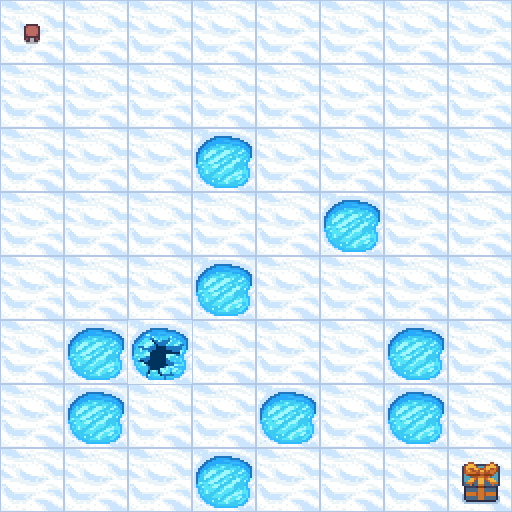

Random policy success rate=0.0


In [4]:
##### DO NOT CHANGE #####
env: FrozenLakeEnv = gym.make("FrozenLake-v1", map_name="8x8", render_mode="rgb_array")
env.reset(seed=SEED)

n_actions = env.action_space.n
n_states = env.observation_space.n
pi_random = np.random.default_rng(SEED).integers(n_actions, size=(n_states,))

success_rate = measure_policy_success(env, pi_random, n_eval=3, render=True, fps=30 if not COLAB else None)

print(f"Random policy success rate={success_rate}")

##### DO NOT CHANGE #####

## Task 1: Policy Iteration
The first algorithm we will implement is called Policy Iteration.
It consists of an inner and an outer loop.
The inner loop is called Policy Evaluation and computes state values for the _current policy_.
For every state, it averages the expected returns of all possible actions in that state, weighted by the current policy's action probabilities.
The outer loop is called Policy Improvement and it uses the current policy's value function to return an improved policy.
It does this by choosing an action for each state that maximizes the expected value of the next state.
In Policy Iteration, we first initialize a policy and value function randomly, and then iteratively run Policy Evaluation and Policy Improvement until convergence.

The **pseudocode** looks as follows:

---
- **Initialize** $V_{(0)}^{\pi_0}(s)$ randomly for all $s$, $\pi_0 \leftarrow$ uniform, $k = 0$

- **Repeat** for $i=1, 2, \dots$

    - **Policy Evaluation:**

        - **Initialize** $V_{(0)}^{\pi_{i}}(s) \leftarrow V_{(k)}^{\pi_{i-1}}(s)$ (i.e. initialize the value function of the new policy with the converged value function of the old policy)

        - **Repeat** for $k=1, 2, \dots$

            \begin{equation*}
                V_{(k)}^{\pi_{i}}(s) \leftarrow \sum_a \pi(a \mid s) \sum_{s'} P(s' \mid s,a) \Big( r(s,a,s') + \overline{d} \gamma \, V_{(k - 1)}^{\pi_{i}}(s') \Big)
            \end{equation*}

        - **Until convergence**

    - **Policy Improvement:**

        \begin{align*}
            \pi_{i}(a \mid s) \leftarrow \begin{cases}
                1, & \text{if } a = \underset{a'}{\arg \max} \sum_{s'} P(s' \mid s,a') \Big( r(s,a',s') + \overline{d} \gamma \, V^{\pi_i}(s') \Big)\\
                0 & \text{else}
            \end{cases}
        \end{align*}

- **Until convergence**
---

Because the reward depends on the next state and not just the action (i.e. $r=r(s,a,s')$), we must slightly update the equations for policy iteration and value iteration seen in the lecture.

Also note the addition of $\overline{d}$ to the formulas from the lecture.
The expected value of some transition is the transition reward plus the (discounted) value of the next state.
However, some transitions result in termination (e.g. falling through the ice).
For these transitions, the trajectory is over and we cannot use the (discounted) value of the next state.

### Task 1.1 (4 Points)

In this first task you have to implement the core algorithm of **policy evaluation** and **policy improvement**, both marked with `# YOUR CODE HERE`.
For convenience in this discrete environment, we maintain both an array called `pi_prob` for the _action probabilities_ and an array called `pi` that just contains the deterministic action that the policy takes in each state.

After you have finished implementing the corresponding functions, execute the code cell.
Your algorithm should be able to solve the task with around ~65% success rate.

Note: the dynamics of the environment are available to you through the `mdp` variable.
If you index this with the state and the action (i.e. `mdp[state][action]`), you are given a list of possible transitions, where each transition is a tuple of the form `(transition_prob: float, next_state: int, reward: float, done: bool)`.
In other words, each transition has an associated probability, reward, and next state.

In [5]:
def policy_evaluation(
    mdp: dict[int, dict[int, list[tuple[float, int, float, bool]]]],
    pi_prob: np.ndarray,
    previous_value: np.ndarray,
    gamma: float,
    max_iters: int = 10000,
) -> np.ndarray:
    """Perform the Policy Evaluation step given a policy pi and an environment.

    :param mdp: an MDP as a list of transitions for each state-action pair
    :param pi_prob: Action probabilities [num_states, num_actions]
    :param previous_value: Initial value function [num_states]
    :return: value function of the provided policy [num_states]
    """
    n_states, n_actions = pi_prob.shape
    for _ in range(max_iters):
        value = np.zeros_like(previous_value)
        # hint: you will need to iterate over states and actions here
        # get a list of possible transitions using mdp[state][action], which returns a list of
        # tuples of (transition_prob, next_state, reward, done)
        
        # YOUR CODE HERE
        for s in range(n_states):
            v_s = 0.0
            # 按当前策略在该状态下对动作求期望
            for a in range(n_actions):
                pi_sa = pi_prob[s, a]
                if pi_sa == 0.0:
                    continue
                # mdp[s][a] = [(transition_prob, next_state, reward, done), ...]
                for trans_prob, next_s, reward, done in mdp[s][a]:
                    # done=True 时不再加未来价值（对应公式里的 \bar{d}）
                    v_s += pi_sa * trans_prob * (
                        reward + (0.0 if done else gamma * previous_value[next_s])
                    )
            value[s] = v_s

        # run policy evaluation until convergence
        if np.allclose(value, previous_value):
            break

        # save current value estimate for next iteration
        previous_value = np.copy(value)

    return value

def policy_improvement(
    mdp: dict[int, dict[int, list[tuple[float, int, float, bool]]]],
    value: np.ndarray,
    gamma: float,
) -> tuple[np.ndarray, np.ndarray]:
    """Perform the Policy Improvement step given a value function.

    :param mdp: an MDP as a list of transitions for each state-action pair
    :param value: Value function of a policy [num_states]
    :return: New policy [num_states] and distribution over action probabilities [num_states, num_actions]
    """
    n_states, n_actions = len(mdp), len(mdp[0])
    # initialize policy
    # contains the actual actions
    pi = np.zeros(shape=n_states, dtype=np.int64)
    # contains the action probabilities for each state
    pi_prob = np.zeros(shape=(n_states, n_actions))

    # hint: This again requires you to iterate over states and actions in some way.
    # get a list of possible transitions using mdp[state][action], which returns a list of
    # tuples of (transition_prob, next_state, reward, done)
    # You can use np.argmax() to get the index of the biggest value in an array.
    
    # YOUR CODE HERE
    for s in range(n_states):
        # 计算每个动作的 Q(s, a)
        action_values = np.zeros(n_actions, dtype=float)
        for a in range(n_actions):
            q_sa = 0.0
            for trans_prob, next_s, reward, done in mdp[s][a]:
                q_sa += trans_prob * (
                    reward + (0.0 if done else gamma * value[next_s])
                )
            action_values[a] = q_sa

        # 选出最优动作（确定性策略）
        best_action = int(np.argmax(action_values))
        pi[s] = best_action
        pi_prob[s, :] = 0.0
        pi_prob[s, best_action] = 1.0

    return pi, pi_prob

def policy_iteration(
    env: FrozenLakeEnv,
    gamma: float,
    n_iters: int,
    max_iters_policy_eval: int = 10000,
    random_init: bool = True,
) -> plt.Figure:
    """Policy Iteration algorithm

    :param env: a FrozenLakeEnv environment
    :param gamma: discount factor
    :param n_iter: number of loop iterations
    :param max_iters_policy_eval: maximum iterations of policy evaluation for each loop iteration
    :param random_init: initialize value function randomly or as all zeros?
    :return: Figure containing final value function and learning curves
    """

    n_states = env.observation_space.n
    n_actions = env.action_space.n
    mdp = env.unwrapped.P
    rng = np.random.default_rng(seed=SEED)
    if random_init:
        value = rng.normal(loc=0, scale=0.5, size=(n_states,))
    else:
        value = np.zeros(shape=n_states)
    pi_prob = (
        np.ones(shape=(n_states, n_actions)) / n_actions
    )  # contains the action probabilities for each state
    pi = np.zeros(shape=n_states, dtype=np.int64)  # contains the actual actions

    # setup plotting
    fig, (ax_value, ax_success, ax_change) = plt.subplots(1, 3, figsize=(12,5))
    fig.subplots_adjust(wspace=0.3)
    grid = (nrow, ncol) = (env.unwrapped.nrow, env.unwrapped.ncol)
    image_value = ax_value.imshow(value.reshape(grid), vmin=0.0, vmax=0.9)
    fig.colorbar(image_value)
    for i in range(nrow):
        for j in range(ncol):
            desc = env.unwrapped.desc[i, j].decode()
            ax_value.text(j, i, desc, ha="center", va="center", color="w")
    ax_success.set(xlabel="Iterations", ylabel="Success Rate")
    ax_success.set_xlim(0, n_iters)
    ax_success.set_ylim(0.0, 1.0)
    line_success, *_ = ax_success.plot([], [])
    ax_change.set(xlabel="Iterations", ylabel="Mean Delta")
    ax_change.set_xlim(0, n_iters)
    ax_change.set_ylim(1e-7, 1.0)
    ax_change.set_yscale("log")
    line_change, *_ = ax_change.plot([], [])

    env.reset(seed=int(rng.integers(2**32)))

    iters = []
    success_rates = []
    mean_delta_values = []
    for iter in range(n_iters):
        previous_value = np.copy(value)
        iters.append(iter + 1)

        # run policy evaluation
        value = policy_evaluation(mdp, pi_prob, value, gamma, max_iters_policy_eval)

        # run policy improvement
        pi, pi_prob = policy_improvement(mdp, value, gamma)

        # evaluate policy success rate
        success_rate = measure_policy_success(env, pi, n_eval=100)
        success_rates.append(success_rate)

        mean_delta_value = np.abs(value - previous_value).mean()
        mean_delta_values.append(mean_delta_value)

        # update plots
        display.clear_output(wait=True)
        image_value.set_data(value.reshape(grid))
        line_success.set_data(iters, success_rates)
        line_change.set_data(iters, mean_delta_values)
        display.display(fig)

    # clear duplicate plot
    display.clear_output(wait=True)

    return fig, success_rates, mean_delta_values, image_value

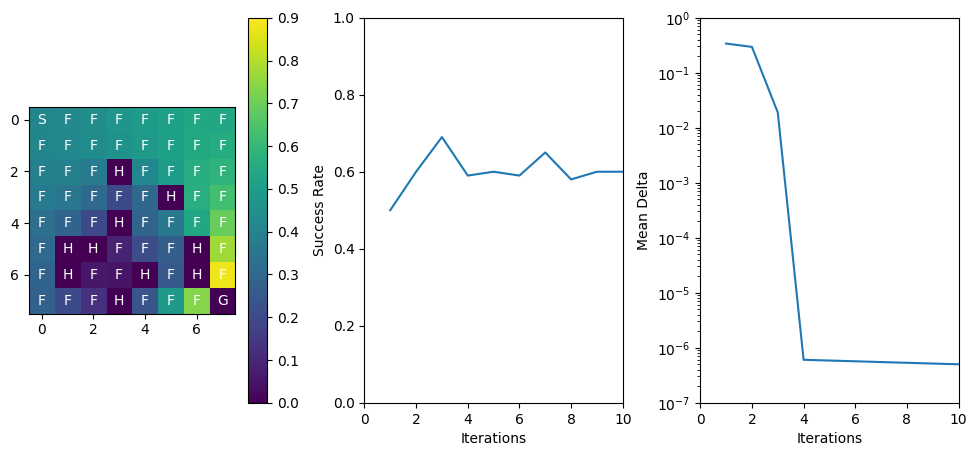

In [6]:
##### DO NOT CHANGE #####
# Run Policy Iteration
fig, success_rates, mean_delta_values, image_value = policy_iteration(
    env,
    gamma=0.99,
    n_iters=10,
    max_iters_policy_eval=10000,
    random_init=True,
)
save_figure(fig, "policy_iteration")

##### DO NOT CHANGE #####

In [7]:
##### DO NOT CHANGE #####
# ID: test_ex_1 - possible points: 4

# Test cells for policy evaluation and policy improvement
test_env = gym.make("FrozenLake-v1", map_name="4x4", render_mode="rgb_array")
test_env.reset(seed=SEED)
test_mdp = test_env.unwrapped.P
test_n_states = test_env.observation_space.n
test_n_actions = test_env.action_space.n

# Test policy_evaluation
test_pi_prob = np.ones(shape=(test_n_states, test_n_actions)) / test_n_actions
test_value = np.zeros(test_n_states)
test_value_result = policy_evaluation(test_mdp, test_pi_prob, test_value, gamma=0.99, max_iters=1000)
assert test_value_result.shape == (test_n_states,), "policy_evaluation should return value function of correct shape"
assert np.all(test_value_result >= 0), "All values should be non-negative for this environment"

# Test policy_improvement  
test_pi, test_pi_prob = policy_improvement(test_mdp, test_value_result, gamma=0.99)
assert test_pi.shape == (test_n_states,), "policy_improvement should return policy of correct shape"
assert test_pi_prob.shape == (test_n_states, test_n_actions), "policy_improvement should return action probabilities of correct shape"
assert np.allclose(np.sum(test_pi_prob, axis=1), 1.0), "Action probabilities should sum to 1 for each state"

print("✓ Basic tests passed for policy_evaluation and policy_improvement")


##### DO NOT CHANGE #####

✓ Basic tests passed for policy_evaluation and policy_improvement


### Self-Test Questions (optional, not graded)

Play with the hyperparameters for this algorithm if you wish.

In this implementation, we stop policy evaluation when we reach convergence or after at most `max_iters_policy_eval` iterations.
Set `max_iters_policy_eval` to $1$, meaning that we only update the values once before using it to improve the policy again.
How much do you need to increase `n_iters` to reach the same level of success as before?

What happens as you increase or decrease `gamma`, the discount factor?
How much can you _decrease_ the `gamma` before the success rate starts to suffer?

Set `gamma` to $1.0$.
Are the final values for the holes (marked "H") $0$, or something else?
If they aren't $0$, perhaps you forgot to take into account terminal states (`done`) during policy evaluation.

Be sure to set to the values back to their original values before generating the figures for submission!

## Task 2: Value Iteration
Next, we will have a look at Value Iteration.
It is very similar to Policy Iteration, except the sum over the policy $\pi(a \mid s)$ has been replaced by a max over actions.
In other words, we no longer consider the current policy during the evaluation step, and instead simply assume that the current policy is always optimal with respect to the current value function.
The **pseudocode** looks as follows

---
- **Initialize** $V_{(0)}^\ast(s)$ randomly for all $s$

- **Repeat** for $i=1, 2, \dots$

    \begin{equation*}
        V^\ast_{(i)}(s) \leftarrow \underset{a}{\max} \sum_{s'} P(s' \mid s,a) \Big( r(s,a,s') + \overline{d} \gamma \, V^\ast_{(i-1)}(s') \Big)
    \end{equation*}

- **Until convergence**
---

Again, note the addition of $\overline{d}$ to the formula from the lecture, to account for terminal states.

### Task 2.1 (4 Points)
In this task you have to implement the core algorithm of **value iteration** (4 points), marked with `# YOUR CODE HERE`.
Since the policy is implicitly defined as the optimal policy for the current value function, you must also compute the updated policy as part of value iteration.

After you have finished implementing the corresponding functions, execute the code cell.
Your algorithm should be able to solve the task with around ~65% success rate.

In [8]:
def value_iteration(
    env: FrozenLakeEnv,
    gamma: float,
    n_iters: int,
    random_init: bool = True,
) -> plt.Figure:
    """Value Iteration algorithm

    :param env: a FrozenLakeEnv environment
    :param gamma: discount factor
    :param n_iter: number of loop iterations
    :param random_init: initialize value function randomly or as all zeros?
    :return: Figure containing final value function and learning curves
    """

    n_states = env.observation_space.n
    n_actions = env.action_space.n
    mdp = env.unwrapped.P
    rng = np.random.default_rng(seed=SEED)
    if random_init:
        value = rng.normal(loc=0, scale=0.5, size=(n_states,))
    else:
        value = np.zeros(shape=n_states)
    pi = np.zeros(shape=n_states, dtype=np.int64)  # contains the actual actions

    # setup plotting
    fig, (ax_value, ax_success, ax_change) = plt.subplots(1, 3, figsize=(12,5))
    fig.subplots_adjust(wspace=0.3)
    grid = (nrow, ncol) = (env.unwrapped.nrow, env.unwrapped.ncol)
    image_value = ax_value.imshow(value.reshape(grid), vmin=0.0, vmax=0.9)
    fig.colorbar(image_value)
    for i in range(nrow):
        for j in range(ncol):
            desc = env.unwrapped.desc[i, j].decode()
            ax_value.text(j, i, desc, ha="center", va="center", color="w")
    ax_success.set(xlabel="Iterations", ylabel="Success Rate")
    ax_success.set_xlim(0, n_iters)
    ax_success.set_ylim(0.0, 1.0)
    line_success, *_ = ax_success.plot([], [])
    ax_change.set(xlabel="Iterations", ylabel="Mean Delta")
    ax_change.set_xlim(0, n_iters)
    ax_change.set_ylim(1e-7, 1.0)
    ax_change.set_yscale("log")
    line_change, *_ = ax_change.plot([], [])

    env.reset(seed=int(rng.integers(2**32)))

    iters = []
    success_rates = []
    mean_delta_values = []
    for iter in range(0, n_iters):
        previous_value = np.copy(value)
        iters.append(iter)

        # hint: Here, you will need to fill in the new policy pi and value function v for all states s.
        # I.e., you need to update pi[s], v[s] for all s.
        # get a list of possible transitions using mdp[state][action], which returns a list of
        # tuples of (transition_prob, next_state, reward, done)
        
        # YOUR CODE HERE
        new_value = np.zeros_like(value)

        for s in range(n_states):
            # 对每个动作计算 Q(s, a)
            action_values = np.zeros(n_actions, dtype=float)
            for a in range(n_actions):
                q_sa = 0.0
                for trans_prob, next_s, reward, done in mdp[s][a]:
                    q_sa += trans_prob * (
                        reward + (0.0 if done else gamma * previous_value[next_s])
                    )
                action_values[a] = q_sa

            # 选取最优动作，并更新价值函数
            best_action = int(np.argmax(action_values))
            pi[s] = best_action
            new_value[s] = action_values[best_action]

        # 把这次迭代得到的新价值函数写回
        value = new_value

        # Evaluate policy success rate
        success_rate = measure_policy_success(env, pi, n_eval=100)
        success_rates.append(success_rate)

        mean_delta_value = np.abs(value - previous_value).mean()
        mean_delta_values.append(mean_delta_value)

        # update plots
        display.clear_output(wait=True)
        image_value.set_data(value.reshape(grid))
        line_success.set_data(iters, success_rates)
        line_change.set_data(iters, mean_delta_values)
        display.display(fig)

    # clear duplicate plot
    display.clear_output(wait=True)

    return fig, success_rates, mean_delta_values, image_value

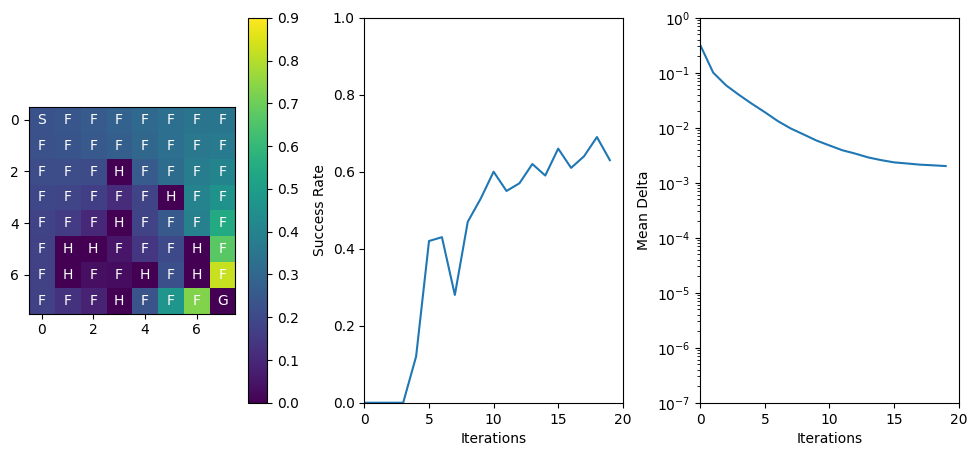

In [9]:
##### DO NOT CHANGE #####
# Run Value Iteration
fig, success_rates, mean_delta_values, image_value = value_iteration(env, gamma=0.99, n_iters=20, random_init=True)
save_figure(fig, "value_iteration")

##### DO NOT CHANGE #####

✓ Basic tests passed for value_iteration


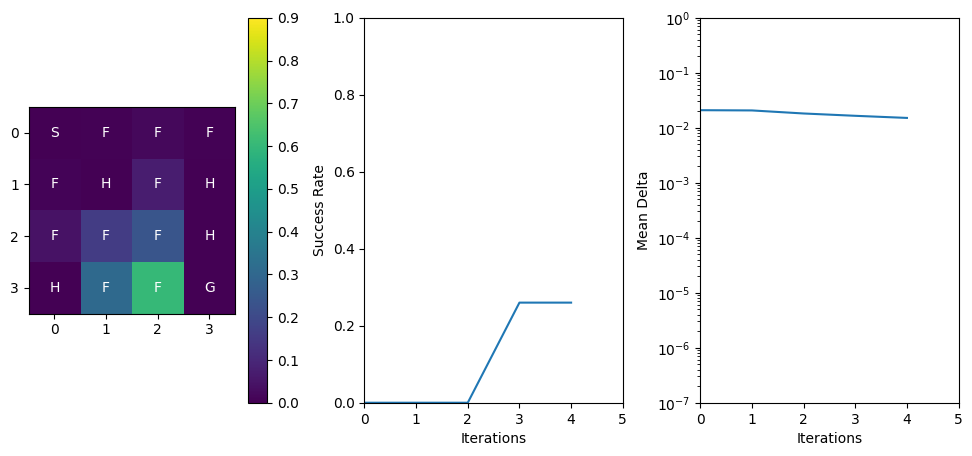

In [10]:
##### DO NOT CHANGE #####
# ID: test_ex_2 - possible points: 4

# Test cell for value_iteration
test_env_vi = gym.make("FrozenLake-v1", map_name="4x4", render_mode="rgb_array")
test_env_vi.reset(seed=SEED)

# Run value iteration with a small number of iterations
test_fig, test_success_rates, test_mean_delta_values, test_image_value = value_iteration(test_env_vi, gamma=0.99, n_iters=5, random_init=False)
assert isinstance(test_fig, plt.Figure), "value_iteration should return a matplotlib Figure"

print("✓ Basic tests passed for value_iteration")


##### DO NOT CHANGE #####

### Self-Test Questions (optional, not graded)

Here we initialize a value function randomly and then run $20$ iterations of value iteration.
How is this different from running $20$ iterations of policy iteration (the previous task) with `max_iters_policy_eval` set to $1$?
Which one converges faster?

The heat map of the value function for policy iteration is noticably lighter (i.e. higher values) than the value function for value iteration.
Is there a reason why policy iteration converges to higher state values than value iteration, or can this discrepancy be resolved?

Play with the hyperparameters for this algorithm if you wish.

What happens if the value function is initialized uniformly to $0$ instead of randomly (set `random_init=False`)?
Why does convergence slow down?

Be sure to set to the values back to their original values before generating the figures for submission!

## Task 3: Q-Learning
In Policy Iteration and Value Iteration, we assume that we have knowledge about the problem's underlying dynamics (the dictionary of transitions) and the reward function.
This information is usually not available in practice.
Instead, we must solve the problem using only the trajectories we have already seen, and ensure we collect sufficient new trajectories through exploration.
One common and effective algorithm for solving such problems is Q-Learning.

The **pseudocode** look as follows:

---
- **Initialize** $Q_{(0)}(s, a)$ randomly for all $s$ and $a$

- **Repeat** for $i=1, 2, \dots$
    - sample an action $a$ using the exploration strategy and get the next state $s'$ and associated reward $r$

    \begin{align*}
        \delta &= r(s, a) + \overline{d} \gamma \underset{a'}{\max} Q_{(i-1)}(s', a') - Q_{(i-1)}(s, a) \\
        Q_{(i)}(s, a) &= Q_{(i-1)}(s, a) + \alpha \delta
    \end{align*}
    
    - If $s'$ is terminal: reset environment and sample new initial state $s'$
    - Set $ s \leftarrow s' $

- **Until convergence**
---

### Task 3.1 (4 Points)
Finally, you have to implement the core algorithm of **QLearning** (4 points), marked with `# YOUR CODE HERE`.
Just like in the pseudocode above, you should first compute the TD-Error $\delta$ and then update the Q function.

After you have finished implementing the corresponding functions, execute the code cell.
If implemented correctly, your algorithm should be able to solve the task with something between 60% and 80% success rate, although the variability is high.

In [11]:
def q_learning(
    env: FrozenLakeEnv,
    alpha_init: float,
    gamma: float,
    n_steps: int,
    t_decay: int | float,
    random_init: bool = True,
) -> plt.Figure:
    """Q-Learning algorithm

    :param env: a FrozenLakeEnv environment
    :param alpha: initial learning rate (decays over time)
    :param gamma: discount factor
    :param n_steps: total number of steps the agent takes in the environment
    :param t_decay: hyperparameter that controls the rate of exploration decay
    :param random_init: initialize Q function randomly or as all zeros?
    :return: Figure containing final value function and learning curve
    """
    eval_every = n_steps // 200
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    rng = np.random.default_rng(SEED)
    if random_init:
        q = rng.normal(loc=0, scale=0.5, size=(n_states, n_actions))
    else:
        q = np.zeros((n_states, n_actions))
    value = np.max(q, axis=1)

    # setup plotting
    fig, (ax_value, ax_success) = plt.subplots(1, 2, figsize=(12,5))
    fig.subplots_adjust(wspace=0.3)
    grid = (nrow, ncol) = (env.unwrapped.nrow, env.unwrapped.ncol)
    image_value = ax_value.imshow(value.reshape(grid), vmin=0.0, vmax=0.9)
    fig.colorbar(image_value)
    for i in range(nrow):
        for j in range(ncol):
            desc = env.unwrapped.desc[i, j].decode()
            ax_value.text(j, i, desc, ha="center", va="center", color="w")
    ax_success.set(xlabel="# Steps", ylabel="Success Rate")
    ax_success.set_xlim(0, n_steps)
    ax_success.set_ylim(0.0, 1.0)
    line_success, *_ = ax_success.plot([], [])

    state, info = env.reset(seed=int(rng.integers(2**32)))

    ts = []
    success_rates = []
    for t in range(n_steps):
        epsilon = max(0.01, 1 - t / t_decay)
        alpha = max(0.01, alpha_init * (1 - t / n_steps))

        # select action using epsilon-greedy method
        # hint: if random() < epsilon, return a random action
        # hint: otherwise return the greedy action, i.e. the one with the highest q
        
        # YOUR CODE HERE
        # ε-greedy：以 epsilon 概率随机探索，否则选 Q 值最大的动作
        if rng.random() < epsilon:
            action = int(rng.integers(n_actions))
        else:
            action = int(np.argmax(q[state]))

        next_state, reward, terminated, truncated, info = env.step(action)

        # compute delta and update Q function
        # hint: Here, you will need to update the Q function with the data from the
        # latest transition above
        # hint: instead of done, use the `terminated` signal here to check if the next state is terminal

        # YOUR CODE HERE
        # Q-learning 核心更新：计算 TD 误差并用学习率 α 更新 Q
        # 注意：只在 terminated=True 时视作真正终止，不再 bootstrap
        max_next_q = np.max(q[next_state]) if not terminated else 0.0
        td_target = reward + gamma * max_next_q
        td_error = td_target - q[state, action]
        q[state, action] = q[state, action] + alpha * td_error

        if terminated or truncated:
            state, info = env.reset()
        else:
            state = next_state

        # evaluate policy success rate
        if t % eval_every == 0:
            value = np.max(q, axis=1)
            pi = np.argmax(q, axis=1)

            ts.append(t)
            success_rate = measure_policy_success(env, pi, n_eval=100)
            success_rates.append(success_rate)

            # update plots
            display.clear_output(wait=True)
            image_value.set_data(value.reshape(grid))
            line_success.set_data(ts, success_rates)
            display.display(fig)

    # clear duplicate plot
    display.clear_output(wait=True)

    return fig, success_rates, image_value

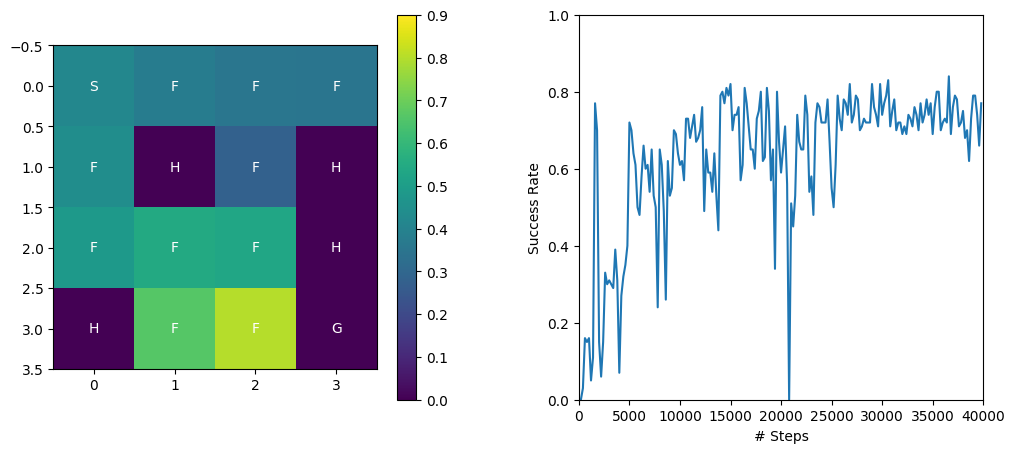

In [12]:
##### DO NOT CHANGE #####
# Run QLearning
small_env: FrozenLakeEnv = gym.make("FrozenLake-v1", map_name="4x4", render_mode="rgb_array")
fig, success_rates, image_value = q_learning(
    small_env,
    alpha_init=0.2,  # initial learning rate (decays over time)
    gamma=0.99,  # discount factor
    n_steps=40000,  # total number of steps the agent takes in the environment
    t_decay=20000,  # controls the rate of exploration decay
    random_init=False,  # initialize Q function randomly or with 0?
)
save_figure(fig, "q_learning")

##### DO NOT CHANGE #####

✓ Basic tests passed for q_learning


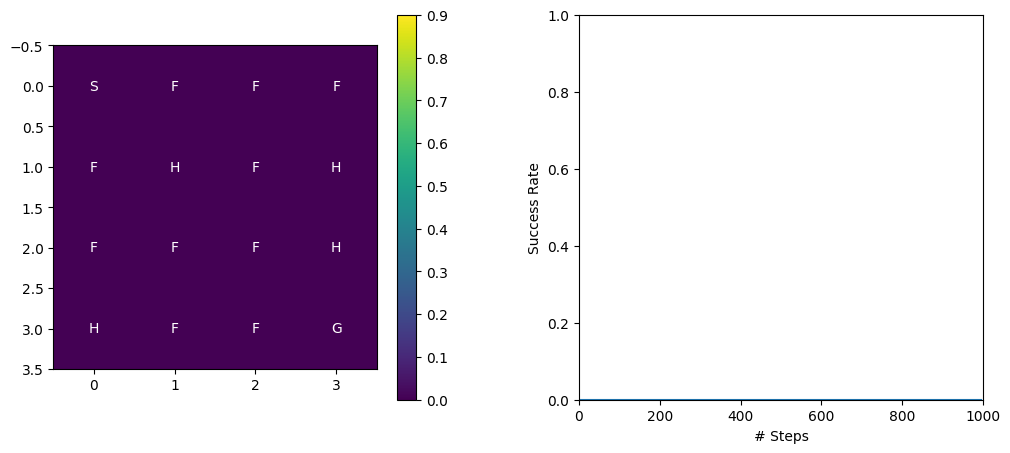

In [13]:
##### DO NOT CHANGE #####
# ID: test_ex_3 - possible points: 4

# Test cell for q_learning
test_env_ql = gym.make("FrozenLake-v1", map_name="4x4", render_mode="rgb_array")
test_env_ql.reset(seed=SEED)

# Run q_learning with a small number of steps
test_fig_ql, test_success_rates, test_image_value = q_learning(test_env_ql, alpha_init=0.2, gamma=0.99, n_steps=1000, t_decay=500, random_init=False)
assert isinstance(test_fig_ql, plt.Figure), "q_learning should return a matplotlib Figure"

print("✓ Basic tests passed for q_learning")


##### DO NOT CHANGE #####

### Self-Test Questions (optional, not graded)

Why do you think that the success rate of Q-learning varies more during learning than it does with policy iteration or value iteration?

When we measure success, we set the policy to be just the argmax over all actions in each state.
Why does this approach hurt exploration, especially during the initial stages of training?

Play with the hyperparameters for this algorithm if you wish.
Can you find better hyperparameters?
Change the random seed as well, to see if your hyperparameters are still good for different random conditions.

What happens if the Q function is initialized randomly instead of uniformly to $0$?
Why does training become much slower?

Be sure to set to the values back to their original values before generating the figures for submission!

### Additional Task 3.2 (not graded)

For the previous task, we used the 4x4 version of the FrozenLake environment because Q-Learning requires many samples and converges quite slowly.
Run the code cell below to try your Q-Learning implementation on the full 8x8 version of the environment.

The algorithm should reach a success rate around $60%$, but sometimes the success rate drops sharply during training.
In my experimentation, the algorithm doesn't learn with `SEED = 6` (leave all other hyperparameters at their defaults).
In addition, there are regions of the environment (e.g. the bottom left) where the Q function still differs from the optimal Q function computed in questions 1 and 2, with no sign that they are improving.
Given this, it is reasonable to wonder if this algorithm will be able to find an optimal policy.

**Question:** Under what conditions (if any) is Q-Learning able to find an optimal policy?

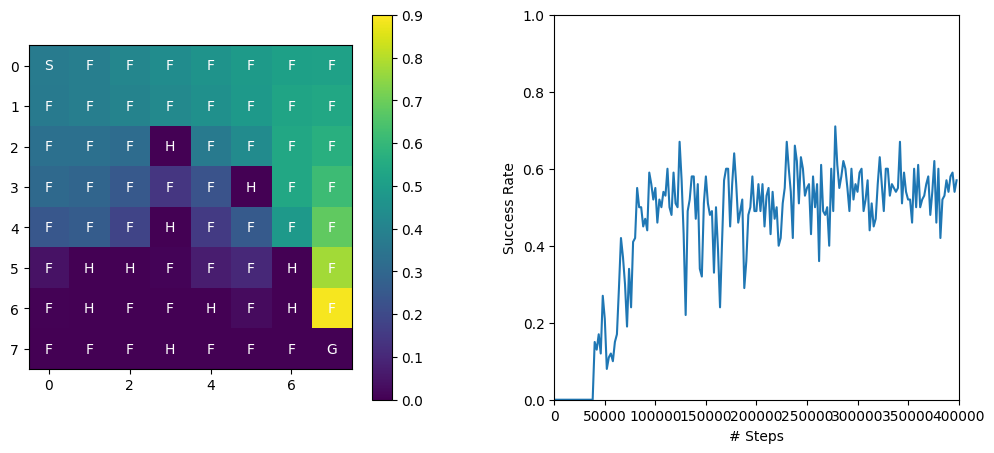

In [14]:
##### DO NOT CHANGE #####
# Run QLearning on the 8x8 environment
SEED = 1
_ = q_learning(env, gamma=0.99, alpha_init=0.2, n_steps=400000, t_decay=200000, random_init=False)

##### DO NOT CHANGE #####